## Test notebook for Data Management Acceptance Test Campaign 1

This test will be executed on the Rubin Science Platform Notebook Aspect at the Interim Data Facility, initialized with Science Pipelines release `w_2022_40`.

### Test case LVV-T72: Verify implementation of Coadd Image Method Constraints

Verify the implementation of how Coadd images are created.


In [1]:
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.geom

import numpy as np
import matplotlib.pyplot as plt

afwDisplay.setDefaultBackend('matplotlib')

#### Instantiate the butler and the default DP0.2 collection:

In [2]:
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

In [3]:
# For this test, we will use a single tract:
tract = 3828

Query the butler for all coadd images (datasetType: `deepCoadd`) in that tract:

In [4]:
data_refs_coadd = butler.registry.queryDatasets(
    datasetType="deepCoadd",
    where=f"tract={tract} and skymap='DC2'")

data_ids_coadd = []

for data_ref in data_refs_coadd:
    # print(data_ref.dataId.full)
    data_ids_coadd.append(data_ref.dataId.full)

Select a few at random to examine in detail:

In [5]:
# Select a few dataIds at random to examine:

numchoices = 3
select_indices = np.random.randint(0, len(data_ids_coadd)+1, size=numchoices)
print(select_indices)

[113 129  49]


For each of the randomly-selected images, confirm that it is well-formed by confirming the shape and size of the image, that the pixels have non-zero (and finite) values, and that there is an associated PSF, WCS, mask and variance planes, and a photocalib.

In [6]:
for ind in select_indices:
    did = data_ids_coadd[ind]
    coadd = butler.get('deepCoadd', dataId=did)
    
    print('dataId: ', did)
    
    # Extract some statistics to confirm it is a well-formed image
    print('\n Image shape and statistics:')
    print('Shape: ', np.shape(coadd.image.array))
    print('Mean, median, std deviation of pixel values: ',
          np.nanmean(coadd.image.array),
          np.nanmedian(coadd.image.array),
          np.nanstd(coadd.image.array))

    # Examine the variance plane associated with the coadd:
    print('\n Variance plane shape and statistics:')
    print('Shape: ', np.shape(coadd.variance.getArray()))
    print('Median of pixel values: ',
          np.nanmedian(coadd.variance.getArray()))

    # Examine the mask plane:
    print('\n Mask plane has the following mask bits set:')
    print(coadd.mask.getMaskPlaneDict())

    print('Mask plane has dimensions: ', coadd.mask.getDimensions())

    # Check for a PSF:
    print('\nHas PSF? ', coadd.hasPsf())
    
    # Check for a WCS and photocalib
    wcs = coadd.getWcs()

    print('\n WCS:')
    print(wcs)

    pcalib = coadd.getPhotoCalib()

    print('\n Photocalib:')
    print(pcalib)
    
    print('\n----------------------------------------------------------')


dataId:  {band: 'g', skymap: 'DC2', tract: 3828, patch: 0}

 Image shape and statistics:
Shape:  (4100, 4100)
Mean, median, std deviation of pixel values:  0.040351667 0.0010676049 2.4728894

 Variance plane shape and statistics:
Shape:  (4100, 4100)
Median of pixel values:  0.0008621462

 Mask plane has the following mask bits set:
{'BAD': 0, 'CLIPPED': 9, 'CR': 3, 'CROSSTALK': 10, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INEXACT_PSF': 11, 'INTRP': 2, 'NOT_DEBLENDED': 12, 'NO_DATA': 8, 'REJECTED': 13, 'SAT': 1, 'SENSOR_EDGE': 14, 'SUSPECT': 7, 'UNMASKEDNAN': 15}
Mask plane has dimensions:  (4100, 4100)

Has PSF?  True

 WCS:
FITS standard SkyWcs:
Sky Origin: (56.6497461929, -36.4462809917)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel

 Photocalib:
spatially constant with mean: 57.544 error: 0

----------------------------------------------------------
dataId:  {band: 'i', skymap: 'DC2', tract: 3828, patch: 31}

 Image shape and statistics:
Shape:  (4200, 4200)


These appear to be well-formed images.

Finally, check one of these randomly-selected coadds to confirm that it has been created from all overlapping visits. To do so, we show the bounding boxes of the input frames via a task in the LSST Science Pipelines:

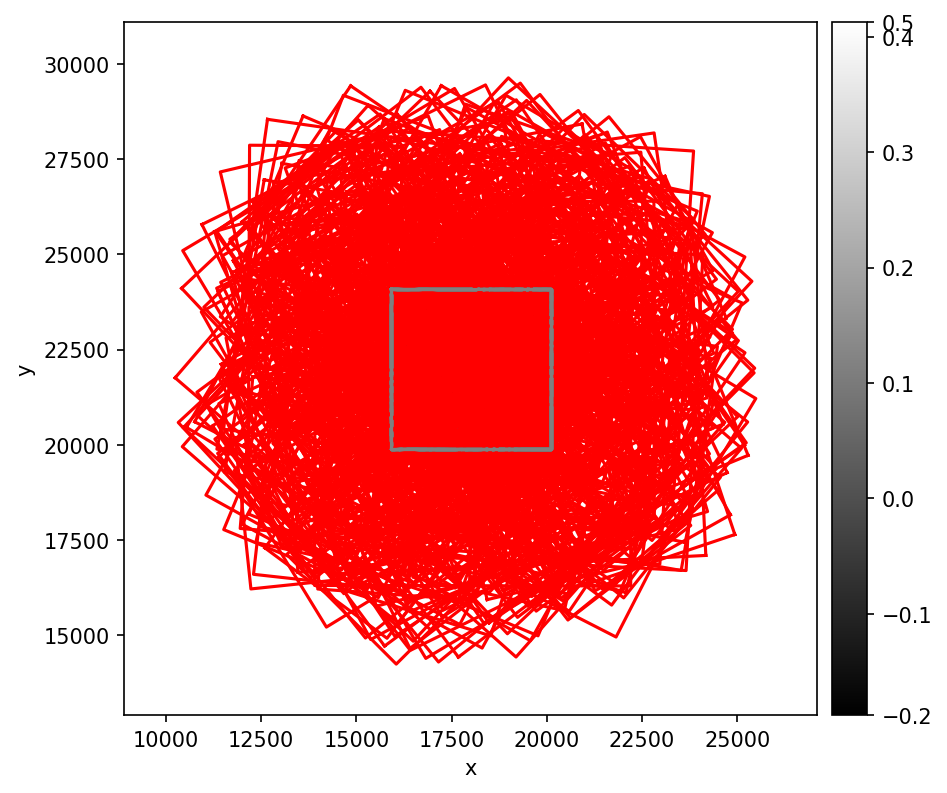

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)

display0 = afwDisplay.Display(frame=1)
display0.scale("linear", "zscale")
display0.mtv(coadd.image)
#afwDisplay.utils.drawCoaddInputs(coadd, frame=1)

coaddWcs = coadd.getWcs()
catalog = coadd.getInfo().getCoaddInputs().ccds
offset = lsst.geom.PointD() - lsst.geom.PointD(coadd.getXY0())

with display0.Buffering():
    for record in catalog:
        ccdBox = lsst.geom.Box2D(record.getBBox())
        ccdCorners = ccdBox.getCorners()
        coaddCorners = [coaddWcs.skyToPixel(record.getWcs().pixelToSky(point))
                        for point in ccdCorners]

        display0.line([(coaddCorners[i].getX(), coaddCorners[i].getY())
                      for i in range(-1, 4)], ctype='Red')

        fullCoaddCorners = coadd.getBBox().getCorners()
        display0.line([(fullCoaddCorners[i].getX(), fullCoaddCorners[i].getY())
                      for i in range(-1, 4)], ctype='Gray')
        
plt.xlabel('x')
plt.ylabel('y')
padding = 7000
plt.ylim(coadd.getY0()-padding, coadd.getY0()+coadd.getHeight()+padding)
plt.xlim(coadd.getX0()-padding, coadd.getX0()+coadd.getWidth()+padding)
plt.show()

We have thus verified that coadd images have been created following the specification in the DMSR.